# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>



In this notebook we investigate the ground state of a single quantum particle 
in one dimension subject to the external potential $V(x) = x^4 - \tfrac{5}{2}x^2$. 
Since the model has no analytic solution, we employ the Variational Monte Carlo 
(VMC) method.  
To optimize the variational parameters, we implement the Simulated Annealing 
(SA) algorithm, which explores the parameter space with a temperature–dependent 
Metropolis scheme. 

This notebook is organized into three main section:

1. [Variational Monte Carlo](#variational-monte-carlo)  
2. [Simulated Annealing](#simulated-annealing)  
3. [Simulated Annealing Validation](#simulated-annealing-validation)  

# Variational Monte Carlo 

### Variational Monte Carlo for a 1D quantum particle

The variational principle in Quantum Mechanics states that the expectation 
value of the Hamiltonian over any trial state provides an upper bound to the 
ground state energy $E_0$:

$$
\langle \hat{H} \rangle_T = 
\frac{\int dx \, \Psi_T^*(x) \hat{H} \Psi_T(x)}
{\int dx \, |\Psi_T(x)|^2} \;\; \geq \;\; E_0 =
\frac{\langle \Psi_0| \hat{H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}.
$$

We consider a single quantum particle in one dimension, 
confined by the external potential

$$
V(x) = x^4 - \tfrac{5}{2}x^2,
$$

which does not admit an analytic ground–state solution and must be solved 
numerically. To approximate the ground state, we introduce the trial wave 
function

$$
\Psi_T^{\sigma,\mu}(x) \propto 
e^{-\frac{(x-\mu)^2}{2\sigma^2}} +
e^{-\frac{(x+\mu)^2}{2\sigma^2}},
$$

depending on two variational parameters, $\mu$ and $\sigma$.  

We note that the expectation value can be rewritten as

$$
\langle \hat{H} \rangle_T =
\int dx \, \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \,
\frac{\hat{H}\Psi_T(x)}{\Psi_T(x)} ,
$$

that is, as the average of the **local energy**

$$
E_{\text{loc}}(x) = \frac{\hat{H}\Psi_T(x)}{\Psi_T(x)}
$$

with respect to the probability density $|\Psi_T(x)|^2$.  
Therefore, we can sample this distribution with the Metropolis Monte Carlo 
algorithm and estimate $\langle \hat{H} \rangle_T$ .

### VMC Implementation

I implemented the Variational Monte Carlo (VMC) method within the NSL_SIMULATOR framework by extending the existing structure to include a dedicated simulation type and the corresponding Metropolis sampling routine.

- **Activation & control flow.** I introduced SIMULATION_TYPE = 4 to enable a VMC branch. In System::step() the VMC path calls move_vmc(); the usual block/step loop (step() → measure() → averages()) in NSL_SIMULATOR.cpp is otherwise unchanged.

- **Degrees of freedom.** The sampler operates on **particle 0 only**, whose coordinate $ x $ **samples the target density** $  |\Psi_T^{\sigma,\mu}(x)|^2  $. All VMC moves and measurements reference particle 0.

- **Uniform Metropolis move.** In System::move_vmc() I propose
  $$x' = x + \xi,\qquad \xi \sim \mathcal U[-\Delta,\Delta],$$
  i.e. a *symmetric* transition; acceptance uses
  $$a=\min\Big\{1,\ \frac{|\Psi_T(x')|^2}{|\Psi_T(x)|^2}\Big\}.$$
  On accept I call acceptmove(), otherwise moveback(). The acceptance is accumulated and written per block.

- **Trial wavefunction and local energy.** I added:
  - psi2_trial(x): $  |\Psi_T(x)|^2 = (g_1+g_2)^2  $ with
    $$g_{1,2}=\exp\!\left[-\frac{(x\mp\mu)^2}{2\sigma^2}\right].$$
  - local_energy(x): analytic
    $$E_{\text{loc}}(x)=V(x)-\tfrac12\,\frac{\Psi_T''(x)}{\Psi_T(x)},\qquad
      V(x)=x^4-\tfrac{5}{2}x^2,$$
    

- **Input interface (VMC-specific).** From ../INPUT/input.dat I read **X0**, **MU**, **SIGMA**, **DELTA** for the VMC run; particle 0 is initialized at X0. Legacy configuration loading is skipped for SIMULATION_TYPE=4.

- **Observables & data blocking.** I registered a new property **LOCAL_ENERGY**. Each step measures $ E_{\text{loc}}(x) $ at the current particle-0 position; averages() prints **block mean**, **cumulative mean**, and **error** (blocking) to ../OUTPUT/local_energy.dat. I also output the Metropolis **acceptance** per block to ../OUTPUT/acceptance.dat.





I performed a VMC simulation using the following settings from input.dat:

-**SIMULATION_TYPE**  = 4  → activates the VMC branch  
-**NPART**  = 1            → only particle 0 is present and updated  
-**DELTA**  = 2.3          → Metropolis step
-**X0**  = 0.9             → initial position of particle 0  
-**MU**  = 0.8             → variational parameter (Gaussian shift)  
-**SIGMA**  = 0.6          → variational parameter (Gaussian width)  
-**NBLOCKS**  = 100        → number of blocks for data blocking  
-**NSTEPS**  = 1000        → Metropolis steps per block  

In the next figure I plot the energy and acceptance in functionn of the number of blocks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_energy_and_acceptance(energy_path="local_energy.dat",
                               acceptance_path="acceptance.dat",
                               usefill=None):
    """
    Load and plot local energy and acceptance data side by side.

    The function creates a figure with 1 row and 2 columns:
        - Left panel: cumulative local energy with error bars (±1σ).
        - Right panel: acceptance vs block.
    """

    # --- Load local energy (columns 0=block, 2=cum_avg, 3=cum_err) ---
    block_e, cum_avg, cum_err = np.loadtxt(
        energy_path, usecols=(0, 2, 3), unpack=True, skiprows=1
    )

    # --- Load acceptance (columns 0=block, 1=acceptance) ---
    block_a, acceptance = np.loadtxt(
        acceptance_path, usecols=(0, 1), unpack=True, skiprows=1
    )

    # --- Create figure with two subplots (1 row × 2 columns) ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.rcParams.update({"font.size": 14})
    # Left panel: cumulative local energy with error bars
    ax1.errorbar(block_e, cum_avg, yerr=cum_err,color='blue', ecolor='red',
                  markersize=3, linewidth=1,label='data')
    ax1.set_xlabel("# Blocks")
    ax1.set_ylabel("Eenrgy")
    ax1.set_title(r" $\langle {\hat H} \rangle_T$ ")
    ax1.grid(True, alpha=0.3)
    
    ##
    if usefill is not None:
        E_best=usefill[0]
        Eerr_best=usefill[1]

        ax1.fill_between(
        block_e,
        E_best - 2*Eerr_best,
        E_best + 2*Eerr_best,
        color='yellow', alpha=0.3,
        label=r'SA best: $ E \pm 2 \sigma$ ' 
        )
        # Add horizontal dashed line at E_best
        ax1.axhline(E_best, color='black', linestyle='--', linewidth=1, label='Best Energy SA')
        E_teoric=-0.46046587969271513
        ax1.axhline(E_teoric, color='green', linestyle='--', linewidth=1, label='E_teorico')

    ax1.legend()
    # Right panel: acceptance vs block
    ax2.plot(block_a, acceptance, '-o', markersize=3, linewidth=1)
    ax2.set_xlabel("# Blocks")
    ax2.set_ylabel("Acceptance")
    ax2.set_title("Acceptance ")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    

    plt.show()





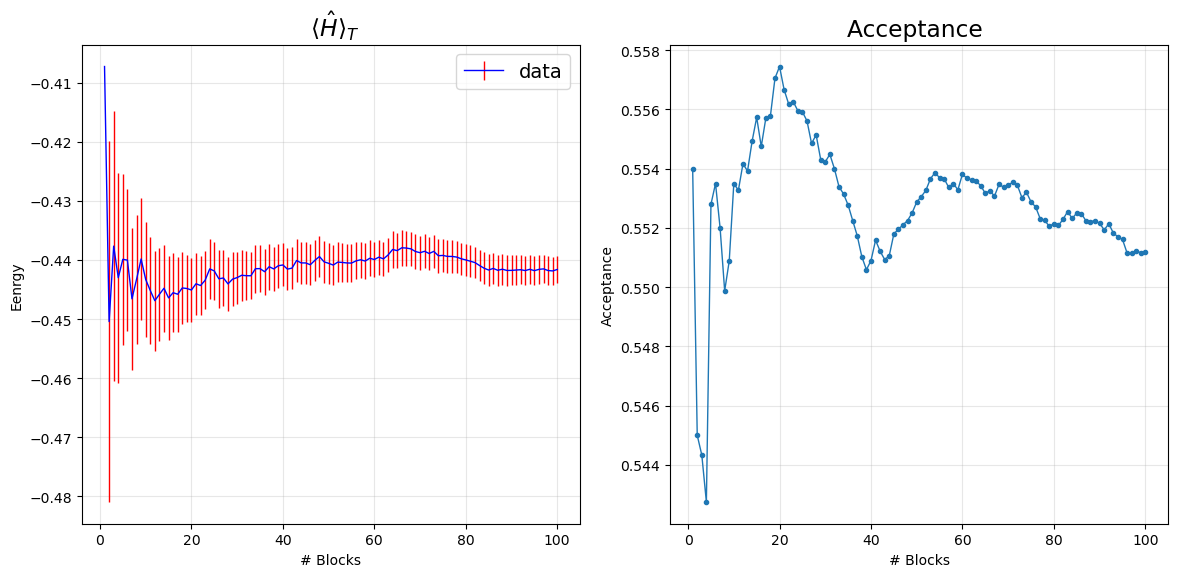

In [2]:
path1="variational_mc/OUTPUT/local_energy.dat"
path2="variational_mc/OUTPUT/acceptance.dat"
plot_energy_and_acceptance(path1, path2)

**Figure 1.** Results of the Variational Monte Carlo simulation with input parameters  
$(\mu=0.8,\, \sigma=0.6,\, \Delta=2.3,\, X_0=0.9)$.  
*Left panel*: block averages of the energy with cumulative mean and one–sigma statistical uncertainty (data blocking).  
*Right panel*: Metropolis acceptance ratio as a function of the numebr of block.


# Simulated Annealing


Simulated annealing (SA) is an optimization algorithm inspired by 
thermodynamics. It mimics how a physical system, when cooled slowly, 
can reach its ordered lowest–energy configuration. If cooling is too fast, 
the system remains trapped in metastable higher–energy states.  

In optimization, the cost function $L(x)$ is interpreted as an “energy”, 
and configurations are sampled according to the Boltzmann distribution  
$p(x) \propto \exp[-\beta L(x)]$. In the low–temperature limit 
($\beta \to \infty$), the probability concentrates on the minima of $L(x)$.  

The algorithm starts from an initial configuration $x_0$ and follows an 
annealing schedule: at each temperature $T=1/\beta$, several Monte Carlo 
steps are performed. A trial move $x \to x'$ is accepted with probability  

$P(x \to x') = 1$ if $\Delta L \leq 0$,  
$P(x \to x') = e^{-\beta \Delta L}$ if $\Delta L > 0$.  

At high $T$ almost all moves are accepted, allowing exploration; as $T$ 
decreases, only downhill moves survive, leading towards minima. With 
sufficiently slow cooling, SA approaches the global minimum of the cost 
function; in practice, it finds configurations close to it, which is often 
sufficient for applications.


### Simulated Annealing applied to the variational problem

In our implementation, simulated annealing (SA) is used as a global 
optimization tool to minimize the variational energy of the trial wave 
function. The variational ansatz depends on two parameters, $\mu$ and 
$\sigma$, which determine the shape of the trial wave function 
$\Psi_T^{\mu,\sigma}(x)$.  

The annealing algorithm proceeds as follows:  
- At a given temperature $T=1/\beta$, a trial move in parameter space 
$(\mu, \sigma) \to (\mu', \sigma')$ is proposed by adding random 
perturbations.  
- For each trial pair $(\mu', \sigma')$, a **Variational Monte Carlo** 
(VMC) simulation is performed, sampling $|\Psi_T^{\mu',\sigma'}(x)|^2$ 
via the Metropolis algorithm and computing the corresponding estimate of 
the energy $\langle H \rangle_{\mu',\sigma'}$.  
- The new parameters are accepted with the Metropolis criterion:  

$P = \min \{ 1, \exp[-\beta (E' - E)] \}$,  

where $E'$ and $E$ are the VMC estimates of the energy with the new and 
old parameters.  

By gradually decreasing the temperature, the algorithm guides the search 
towards low–energy regions of parameter space. In this way, SA provides 
a robust strategy to optimize the trial wave function, avoiding trapping 
in local minima and yielding values of $\mu$ and $\sigma$ close to the 
global variational optimum.


### Implementation of Simulated Annealing in NSL_Simulator

To apply simulated annealing (SA) to the variational Monte Carlo (VMC) problem, 
the original VMC main loop (nested for over blocks and steps) was refactored 
into a dedicated method run_vmc(mu, sigma). This routine performs a full VMC 
simulation with given variational parameters, returning the average local energy 
with statistical error from data blocking.  

A new method simulated_annealing(T) was added in system.cpp. For each 
temperature, the algorithm proposes new values of $(\mu,\sigma)$ with uniform 
random displacements and evaluates their energy through run_vmc. The Metropolis 
criterion is then applied to decide acceptance, with probability 
$P = \min \{1, \exp[-\beta (E' - E)]\}$. The best parameters and energies are 
stored to file together with acceptance rates.  

Additional input parameters (INVERSE_DT, DELTA_MU, DELTA_SIGMA, 
SA_STEPS) were introduced in input.dat to control the annealing schedule.  
This design cleanly separates the VMC routine from the SA optimization, making 
the code modular and extensible.


### SA optimization setup

I performed a simulated annealing (SA) optimization with the following 
input parameters:

- **SIMULATION_TYPE 4**   -> activates the VMC routine  
- **TEMP 0.1**            -> initial temperature of the SA schedule  
- **NPART 1**             -> number of particles (single particle VMC)  
- **DELTA 2.3**           -> Metropolis step size for particle moves  
- **X0 0.0**              -> starting position of the particle  
- **MU 1.0**              -> initial value of the variational parameter $\mu$  
- **SIGMA 0.7**           -> initial value of the variational parameter $\sigma$  
- **NBLOCKS 100**         -> number of blocks in data blocking  
- **NSTEPS 1000**          -> number of VMC steps per block  
- **INVERSE_DT 0.0005**   -> decrement of temperature at each SA step  
- **DELTA_MU 0.01**       -> maximum random displacement for $\mu$ proposals  
- **DELTA_SIGMA 0.01**    -> maximum random displacement for $\sigma$ proposals  
- **SA_STEPS 50**         -> number of SA moves performed at each temperature  


In the next figure I plotted $\langle \hat{H} \rangle_T$ as a function of $\beta$ with statistical uncertainties, together with the trajectory of the parameters in the $(\mu,\sigma)$ space.


In [90]:

def plot_sa_summary(path="simulated_annealing/OUTPUT/energy_SA_new.dat"):
    # Carico i dati dal file
    T, mu, sigma, E, Eerr = np.loadtxt(
        path, comments="#", usecols=(0,1,2,3,4), unpack=True
    )
    N = len(mu)
    beta = 1.0 / T

    fig, axes = plt.subplots(1, 2, figsize=(14,6))

    # --- Subplot sinistro: energia vs beta ---
    ax = axes[0]
    ax.errorbar(beta, E, yerr=Eerr, color='blue', ecolor='red', fmt='o')
    ax.set_xlabel(r"$\beta = 1/T$")
    ax.set_ylabel(r"$\langle \hat{H} \rangle_T$")
    ax.set_title(r"SA: $\langle \hat{H} \rangle_T$ vs $\beta$")
    ax.grid(True)

    # --- Subplot destro: traiettoria (mu, sigma) ---
    ax = axes[1]

    # primi 20 passi
    n_first = min(20, N)
    ax.plot(mu[:n_first], sigma[:n_first], '-o', color='blue', markersize=4, linewidth=1, label="first steps")

    # ultimi 20 passi
    n_last = min(20, N)
    ax.plot(mu[-n_last:], sigma[-n_last:], '-o', color='green', markersize=4, linewidth=1, label="last steps")

    # intermedi
    if N > (n_first + n_last):
        ax.plot(mu[n_first:-n_last], sigma[n_first:-n_last], '-', color='lightgray', linewidth=1)

    # start (pallino blu)
    ax.plot(mu[0], sigma[0], 'o', color='blue', markersize=8, label="start")

    # end (pallino rosso)
    ax.plot(mu[-1], sigma[-1], 'o', color='red', markersize=8, label="end")

    # energia minima (stella gialla)
    idx_min = np.argmin(E)
    ax.plot(mu[idx_min], sigma[idx_min], '*', color='purple', markersize=14, label="best")

    ax.set_xlabel(r"$\mu$")
    ax.set_ylabel(r"$\sigma$")
    ax.set_title("SA trajectory in parameter space")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

def best_parameters():      
      T, mu, sigma, E, Eerr = np.loadtxt("simulated_annealing/OUTPUT/energy_SA_new.dat", comments="#", usecols=(0,1,2,3,4),unpack=True)

      # Trovo l'indice dell'energia minima
      idx_min = np.argmin(E)

      # Estraggo i valori corrispondenti
      T_min     = T[idx_min]
      mu_min    = mu[idx_min]
      sigma_min = sigma[idx_min]
      E_min     = E[idx_min]
      Eerr_min  = Eerr[idx_min]

      print("Min energy found:")
      print(f"1/T = {(1/T_min):.4f}, mu = {mu_min:.4f}, sigma = {sigma_min:.4f}, "
            f"E = {E_min:.6f} ± {Eerr_min:.6f}")

      return T_min, mu_min, sigma_min, E_min,Eerr_min 


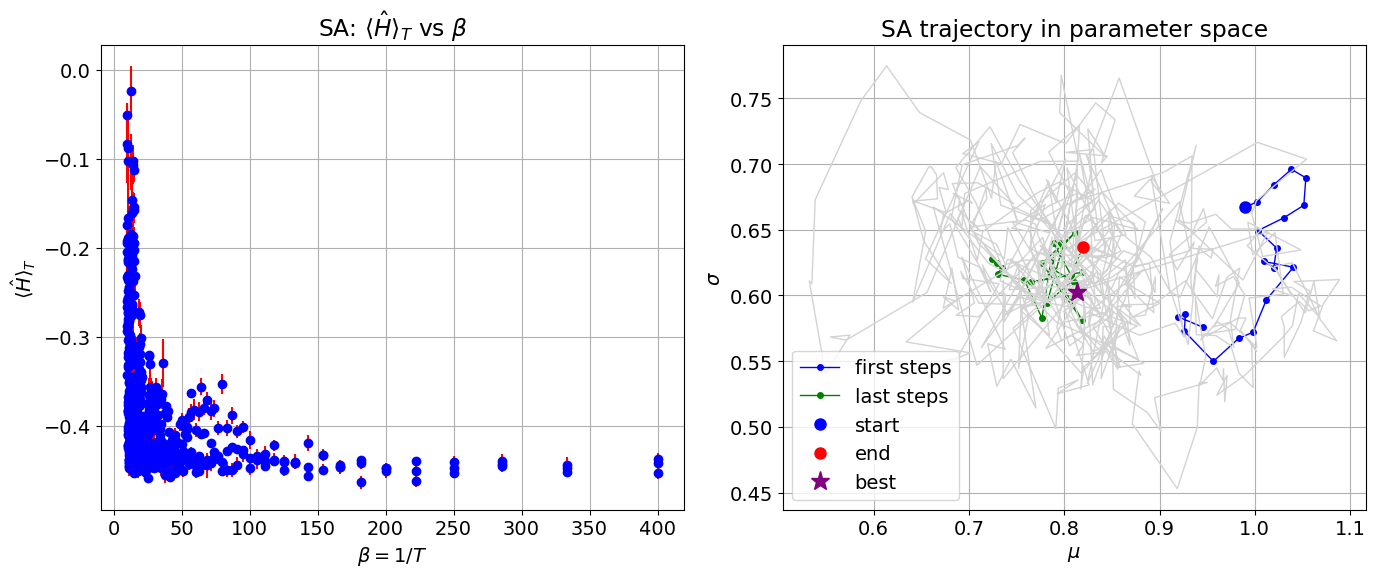

In [93]:
plot_sa_summary()


**Figure 2:** Simulated Annealing optimization. Left panel: behavior of the variational energy $\langle \hat{H} \rangle_T$ as a function of $\beta = 1/T$ with statistical uncertainties. Right panel: trajectory in the $(\mu,\sigma)$ parameter space during the annealing procedure. The starting point, final configuration, and best parameters are highlighted.



Figure 2 summarizes the simulated annealing optimization of the 
variational parameters. In the left panel, the variational energy 
$\langle \hat{H} \rangle_T$ decreases as $\beta$ increases, showing 
convergence towards low–energy configurations. The statistical error 
bars confirm the stability of the estimate at large $\beta$.  

The right panel shows the trajectory in the $(\mu,\sigma)$ parameter 
space. The algorithm explores a broad region at high temperature 
(first steps in blue) and progressively concentrates around the optimal 
parameters as the temperature decreases (last steps in green). The 
starting configuration, final point, and best solution found by SA are 
marked explicitly.  

This behavior demonstrates that SA successfully avoids local minima 
and guides the search towards the variational optimum.

The algorithm found the minimum energy :

In [92]:
T_min, mu_min, sigma_min, E_min,Eerr_min =best_parameters()

Min energy found:
1/T = 181.8182, mu = 0.8137, sigma = 0.6027, E = -0.463508 ± 0.006905


# Simulated annealing validation

### Simulated Annealing validation

To validate the simulated annealing (SA) optimization, a new Variational 
Monte Carlo (VMC) simulation was performed using the best parameters 
$(\mu, \sigma)$ obtained from SA. The resulting variational energy was 
then compared with both the estimate from the SA optimization and the 
reference energy computed by solving the Schrödinger equation with the 
matrix method. The agreement between these results confirms the 
reliability of the SA procedure in finding near–optimal variational 
parameters.  

In addition to the energy comparison, we analyzed the probability 
density $|\psi_T(x)|^2$. The distribution sampled in the VMC run with 
optimized parameters was plotted together with the squared modulus of 
the ground–state wave function obtained from the matrix solution and 
with the analytical ansatz evaluated at the best $(\mu, \sigma)$.


### Matrix resolution

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.

Below I define the Python function matrix_solution(N), which computes the eigenstates and eigenvalues of the Hamiltonian.

In [96]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

def matrix_solution(N=100):  
    #--IMPLEMENTATION MATRIX RESOLUTION
    # N number of iterations
    hbar = 1
    m = 1
    a = 6 #settore sulle x dove vado acercare il minimo cit. prof
    

    # Step sizes
    x = np.linspace(-a/2, a/2, N)
    dx = x[1] - x[0] # the step size
    V = Vpot(x)

    # The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

    CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1) 
    # np.diag(np.array,k) construct a "diagonal" matrix using the np.array
    # The default is k=0. Use k>0 for diagonals above the main diagonal, 
    # and k<0 for diagonals below the main diagonal

    # Hamiltonian matrix
    H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

    # Compute eigenvectors and their eigenvalues
    E,psi = np.linalg.eigh(H)

    # Take the transpose & normalize
    psi = np.transpose(psi)
    psi = psi/np.sqrt(dx)
    return psi, E


In [99]:


def plot_summary(energy_path="vmc_best/OUTPUT/local_energy.dat",
                 acceptance_path="vmc_best/OUTPUT/acceptance.dat",
                 density_path="vmc_best/OUTPUT/prob_density.dat",
                 E_teoric= E_min, mu_min=None, sigma_min=None, usefill=None):
    """
    Plot summary of VMC results:
      - Top row: (left) cumulative local energy with error bars,
                 (right) acceptance vs block
      - Bottom row: histogram of |psi_T|^2 with comparison to ansatz and matrix solution
    """

    # --- Load local energy (columns 0=block, 2=cum_avg, 3=cum_err) ---
    block_e, cum_avg, cum_err = np.loadtxt(
        energy_path, usecols=(0, 2, 3), unpack=True, skiprows=1
    )

    # --- Load acceptance (columns 0=block, 1=acceptance) ---
    block_a, acceptance = np.loadtxt(
        acceptance_path, usecols=(0, 1), unpack=True, skiprows=1
    )

    # --- Load prob_density (columns 1=x, 3=hist_prog, 4=err) ---
    x_d, hist_prog, err_d = np.loadtxt(
        density_path, comments="#", usecols=(1, 3, 4), unpack=True
    )

    # --- Prepare figure (2 rows: top=2 cols, bottom=1 col) ---
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

    # curve from external functions if available
    psi, E = matrix_solution()

    # Top-left: Energy
    ax1 = fig.add_subplot(gs[0,0])
    ax1.errorbar(block_e, cum_avg, yerr=cum_err,
                 color='blue', ecolor='red',
                 markersize=3, linewidth=1, label='data')
    ax1.set_xlabel("# Blocks")
    ax1.set_ylabel("Energy")
    ax1.set_title(r"$\langle \hat{H} \rangle_T$")
    ax1.grid(True, alpha=0.3)

    if usefill is not None:
        E_best, Eerr_best = usefill
        ax1.fill_between(
            block_e,
            E_best - 2*Eerr_best,
            E_best + 2*Eerr_best,
            color='yellow', alpha=0.3,
            label=r'SA best: $E \pm 2\sigma$'
        )
        ax1.axhline(E_best, color='black', linestyle='--', linewidth=1, label='Best Energy SA')
       
        ax1.axhline(E[0], color='green', linestyle='--', linewidth=1, label='E_matrix')
    ax1.legend()

    # Top-right: Acceptance
    ax2 = fig.add_subplot(gs[0,1])
    ax2.plot(block_a, acceptance, '-o', markersize=3, linewidth=1)
    ax2.set_xlabel("# Blocks")
    ax2.set_ylabel("Acceptance")
    ax2.set_title("Acceptance")
    ax2.grid(True, alpha=0.3)

    # Bottom (merge columns): Probability density
    ax3 = fig.add_subplot(gs[1,:])
    width = x_d[1]-x_d[0] if len(x_d) > 1 else 0.1
    ax3.bar(x_d, hist_prog, width=width,
            yerr=err_d, align='center', alpha=0.7,
            color='blue', ecolor='red', capsize=2, label=r'$|\psi_T|^2$ (VMC)')
    
    
    ax3.plot(x_d, (psi[0])**2, color='green', label='matrix')
    
    
    if mu_min is not None and sigma_min is not None:
        try:
            ax3.plot(x_d, psi2_ansatz(x_d, mu_min, sigma_min), color='black', label='analytical')
        except NameError:
            pass

    ax3.set_xlabel("x")
    ax3.set_ylabel("Probability density")
    ax3.set_title(r"Histogram of $|\psi_T(x)|^2$ from VMC sampling")
    ax3.grid(alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.show()


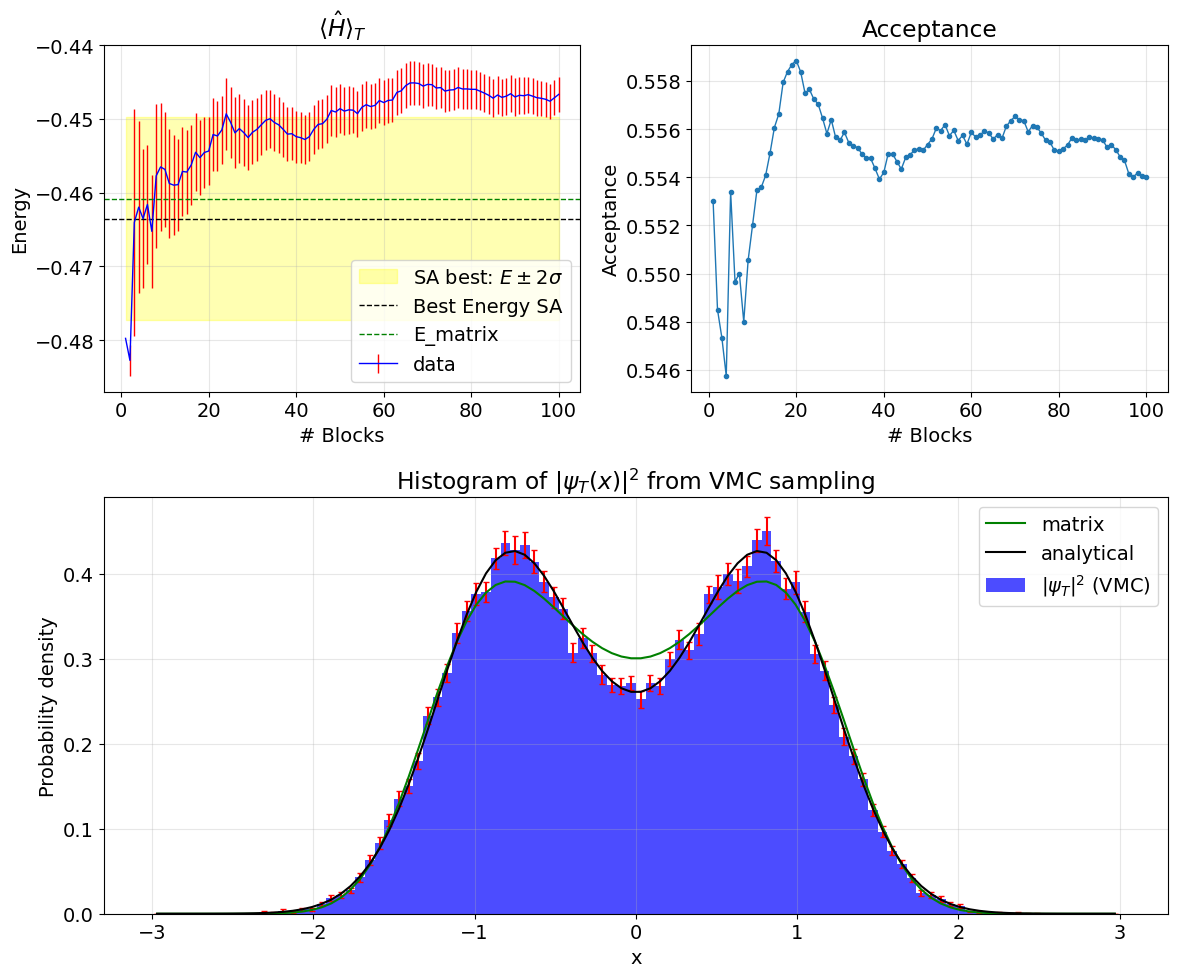

In [100]:
plot_summary(mu_min=mu_min, sigma_min=sigma_min, usefill=[E_min,Eerr_min])

**Figure 3:** Validation of the simulated annealing optimization.
Top-left: cumulative average of the variational energy with statistical errors, compared with the best energy found by SA (black dashed line) and with the theoretical ground–state value (green dashed line). The yellow band corresponds to the SA estimate with $\pm 2\sigma$ uncertainty.
Top-right: acceptance ratio as a function of the block index, showing stable values around $55\%$ .
Bottom: histogram of the probability density $|\psi_T(x)|^2$ obtained from the VMC sampling with optimized parameters, compared with the ground–state wave function from the matrix solution (green line) and with the analytical ansatz evaluated at the best $(\mu,\sigma)$ (black line).

The SA energy appears slightly lower than the matrix reference, but this is due to statistical fluctuations and remains consistent with the variational principle.
The VMC estimate converges to values 
fully consistent with both $E_{\mathrm{SA}}$ and the theoretical 
benchmark, remaining well within the statistical confidence intervals. 
Occasional values slightly below the exact ground state appear, but always 
inside the error bars, as expected from Monte Carlo fluctuations and in 
agreement with the variational principle.  

In the right panel we show the acceptance ratio as a function of the block 
index. After some initial oscillations, the acceptance stabilizes around 
$\sim 55\%$, which is considered optimal for an efficient sampling: 
not too low (chain frozen) and not too high (moves too small).  

The figure confirms the statistical correctness of the 
calculation: the VMC run with SA–optimized parameters produces results 
compatible with the annealing estimate and the theoretical value, with 
controlled uncertainties and an efficient acceptance ratio.
